In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import *
from catboost import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pickle
import tensorflow as tf
import shap
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import *
import os

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, style='whitegrid', palette=palette)  # 解决Seaborn中文显示问题

data = pd.read_excel('../../原始数据/附件1：物流网络历史货量数据.xlsx')


In [27]:
def getxy():
    targetKey = '货量'
    # 对场地进行编码

    df = data[(data['场地1'] == 'DC14') & (data['场地2'] == 'DC10')]
    df.reset_index(inplace=True)
    df['场地1'] = df['场地1'].str.replace('DC', '')
    df['场地1'] = df['场地1'].astype('int64')
    df['场地2'] = df['场地2'].str.replace('DC', '')
    df['场地2'] = df['场地2'].astype('int64')

    df['日期'] = pd.to_datetime(df['日期'])
    df['日期'] = df['日期'] - df['日期'].min()
    df['日期'] = df['日期'].apply(lambda x: x.days)

    df['货量'] = np.log10(df['货量'])
    return df.drop(targetKey, axis=1), df[targetKey], df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

23/23 [==============================] - 0s 7ms/step


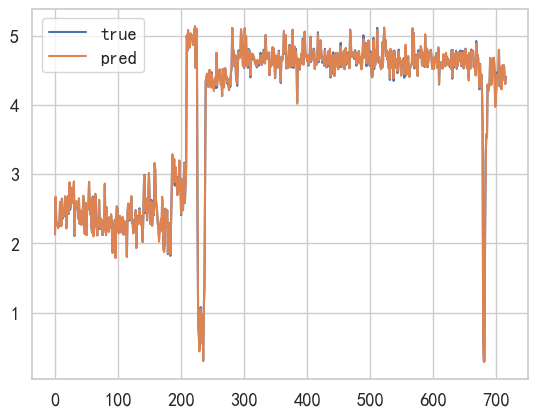

In [34]:
modelPath = 'my_model.h5'
X, Y, df = getxy()

# 将时间序列转换为监督学习问题
n_lags = 10
n_features = 1
seq_len = n_lags
X_train, y_train = [], []
for i in range(n_lags, len(df)):
    X_train.append(df['货量'][i - n_lags:i])
    y_train.append(df['货量'][i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], seq_len, n_features))

if not os.path.exists(modelPath):
    # 创建LSTM模型
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(100, input_shape=(seq_len, n_features)),
        # tf.keras.layers.LSTM(100),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')

    # 训练模型
    history = model.fit(X_train, y_train, epochs=5000)

    # 保存模型
    model.save(modelPath)

    # 绘制训练误差曲线
    plt.plot(history.history['loss'])
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
else:
    # 加载模型并继续训练
    model = tf.keras.models.load_model(modelPath)


# 测试模型
y_pred = model.predict(X_train)

# 绘制预测结果和真实值的比较图
plt.plot(y_train, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()


In [35]:
np.power(10, y_pred)

array([[1.33370819e+02],
       [4.73350464e+02],
       [2.19231659e+02],
       [1.82223602e+02],
       [1.88846619e+02],
       [1.65913696e+02],
       [1.99573212e+02],
       [1.85146667e+02],
       [3.98345581e+02],
       [3.50690125e+02],
       [1.76770126e+02],
       [4.33332031e+02],
       [2.36174026e+02],
       [2.76459839e+02],
       [2.98452179e+02],
       [2.53615891e+02],
       [4.82212006e+02],
       [4.66141571e+02],
       [1.64045441e+02],
       [3.24177399e+02],
       [3.97802551e+02],
       [4.90531525e+02],
       [2.65297394e+02],
       [7.63314575e+02],
       [3.25654480e+02],
       [3.58189941e+02],
       [6.38722412e+02],
       [5.72932678e+02],
       [4.60188477e+02],
       [3.77578339e+02],
       [7.87684082e+02],
       [1.31455414e+02],
       [2.88810059e+02],
       [3.54496765e+02],
       [4.06827484e+02],
       [3.63771301e+02],
       [3.83463287e+02],
       [2.26549240e+02],
       [4.48928894e+02],
       [1.94809723e+02],


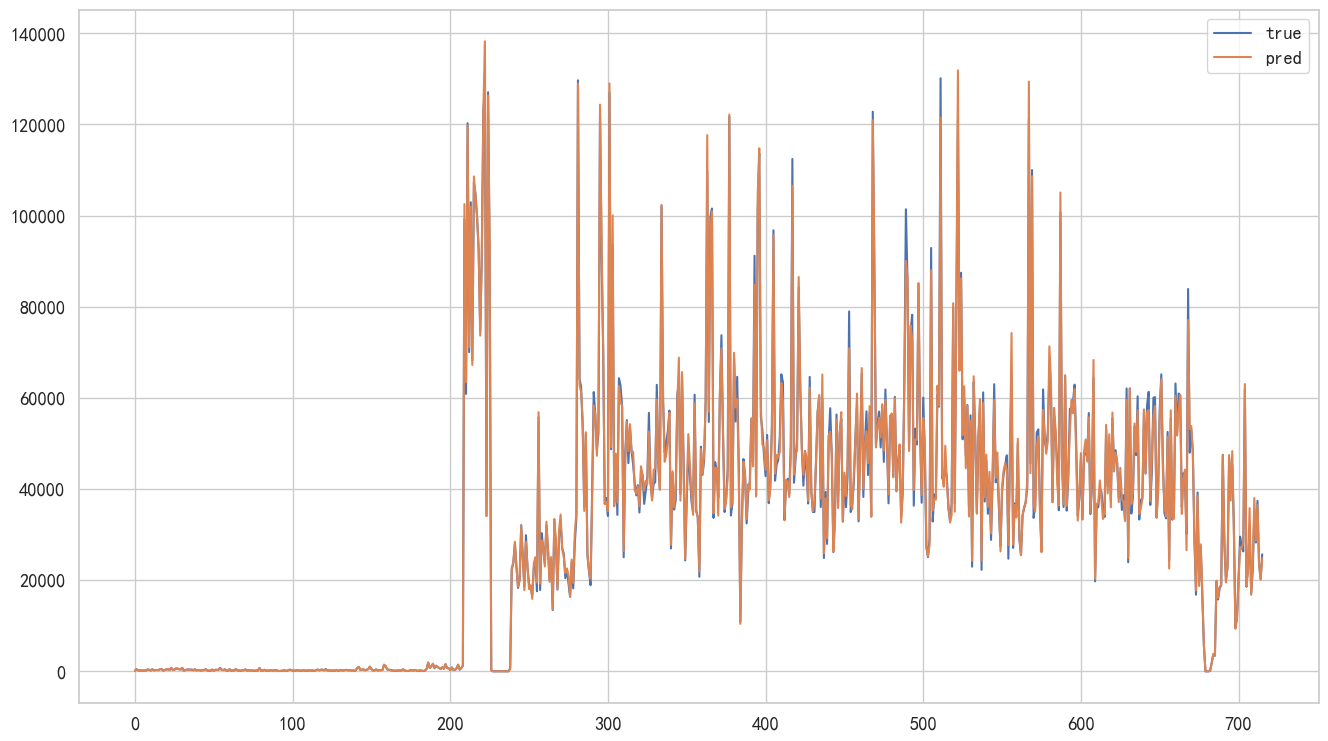

r2 0.9958505723054651


In [36]:
plt.figure(figsize=(16, 9))
plt.plot(np.power(10, y_train), label='true')
plt.plot(np.power(10, y_pred), label='pred')
plt.legend()
plt.show()

print('r2', r2_score(np.power(10, y_train), np.power(10, y_pred)))